# **다중 분류 모델 실습**


## **1. 환경준비**

In [ ]:
# 라이브러리 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

# 디바이스 준비
device = 'cuda' if torch.cuda.is_available() else 'cpu'

* 딥러닝을 위한 데이터로더 만들기

In [ ]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :
    # 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # TensorDataset 생성: 텐서 데이터 세트로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [ ]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset) # 전체 데이터 세트의 크기
    num_batches = len(dataloader) # 배치 크기
    tr_loss = 0

    model.train() # 학습 모드로 설정
    for x, y in dataloader: # 배치 단위로 로딩
        x, y = x.to(device), y.to(device) # 디바이스 지정

        # Feed Forward(오차 순전파)
        pred = model(x)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation(오차 역전파)
        loss.backward() # 역전파를 통해 각 파라미터에 대한 오차의 기울기 계산
        optimizer.step() # 옵티마이저가 모델의 파라미터를 업데이트
        optimizer.zero_grad() # 옵티마이저의 기울기값 초기화.

    tr_loss /= num_batches # 모든 배치의 오차 평균
    return tr_loss.item()

* 검증을 위한 함수

In [ ]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval() # 모델을 평가 모드로 설정

    with torch.no_grad(): # 평가 과정에서 기울기를 계산하지 않도록 설정
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item() # 예측값 pred와 목푯값 y 사이의 오차 계산

    return eval_loss, pred

* 학습곡선

In [ ]:
def dl_learning_curve(tr_loss_list, val_loss_list):
    epochs = list(range(1, len(tr_loss_list)+1)) # 에포크 수 계산
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.') # 학습 오차 그래프
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.') # 검증 오차 그래프
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

## **2. 다중 분류 모델링 실습 1 - iris**

### (1) 데이터 전처리

In [ ]:
path = 'https://bit.ly/irisdata_csv'
data = pd.read_csv(path)
data.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
target = 'Species'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

* y의 전처리: 정수 인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(type(y))

<class 'numpy.ndarray'>


In [ ]:
print(le.classes_)
y_orig = le.inverse_transform(y)

['setosa' 'versicolor' 'virginica']


* train, val 분할, 스케일링, 데이터 로더 준비

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state=20)

# 스케일링
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

# 데이터 로더
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val, 32)

### (2) 모델링

In [ ]:
n_feature = x.shape[1]
n_class = len(le.classes_)

# 모델 구조 설계
model = nn.Sequential(
            nn.Linear(n_feature, n_class),
            ).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.1)

In [ ]:
epochs = 50
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f'Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}')

Epoch 1, train loss : 0.942299, val loss : 0.873268
Epoch 2, train loss : 0.775378, val loss : 0.778419
Epoch 3, train loss : 0.633500, val loss : 0.657192
Epoch 4, train loss : 0.585050, val loss : 0.602158
Epoch 5, train loss : 0.513315, val loss : 0.575619
Epoch 6, train loss : 0.444863, val loss : 0.553832
Epoch 7, train loss : 0.440353, val loss : 0.521625
Epoch 8, train loss : 0.388806, val loss : 0.488569
Epoch 9, train loss : 0.414819, val loss : 0.486657
Epoch 10, train loss : 0.362414, val loss : 0.457228
Epoch 11, train loss : 0.377382, val loss : 0.447189
Epoch 12, train loss : 0.334538, val loss : 0.441540
Epoch 13, train loss : 0.324914, val loss : 0.459402
Epoch 14, train loss : 0.308437, val loss : 0.446550
Epoch 15, train loss : 0.331319, val loss : 0.423114
Epoch 16, train loss : 0.300689, val loss : 0.410905
Epoch 17, train loss : 0.317380, val loss : 0.405843
Epoch 18, train loss : 0.321395, val loss : 0.398392
Epoch 19, train loss : 0.287863, val loss : 0.397141
Ep

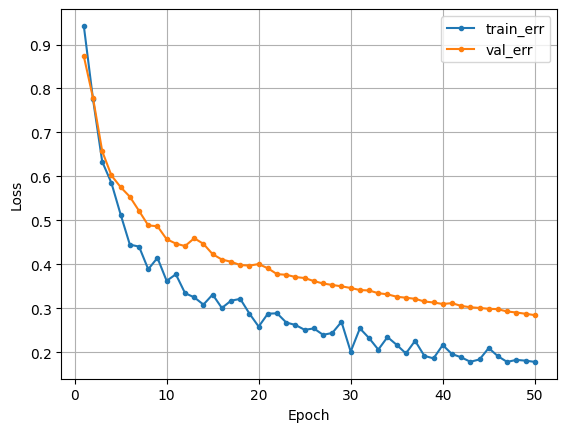

In [ ]:
dl_learning_curve(tr_loss_list, val_loss_list)

In [ ]:
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)
print(pred.numpy()[:3])

[[ 5.040742    0.91104615 -5.3330064 ]
 [-3.6931448   0.8774078  -0.6071758 ]
 [-3.707015    0.5701504  -0.53278637]]


In [ ]:
pred = nn.functional.softmax(pred, dim=1)
print(pred[:3])

tensor([[9.8414e-01, 1.5833e-02, 3.0746e-05],
        [8.3692e-03, 8.0844e-01, 1.8319e-01],
        [1.0315e-02, 7.4307e-01, 2.4662e-01]])


In [ ]:
pred = np.argmax(pred.numpy(), axis = 1)
pred[:3]

array([0, 1, 1])

In [ ]:
print(confusion_matrix(y_val_ts.numpy(), pred))
print(classification_report(y_val_ts.numpy(), pred, target_names=le.classes_))

[[13  0  0]
 [ 0 17  1]
 [ 0  4 10]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       0.81      0.94      0.87        18
   virginica       0.91      0.71      0.80        14

    accuracy                           0.89        45
   macro avg       0.91      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45



## **3. 다중 분류 모델링 실습 2 - MNIST**

### (1) 데이터 전처리

* 데이터 세트 다운로드

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_dataset = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor() )
test_dataset = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor() )

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.39MB/s]


In [ ]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
train_dataset.data.shape, train_dataset.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [ ]:
train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

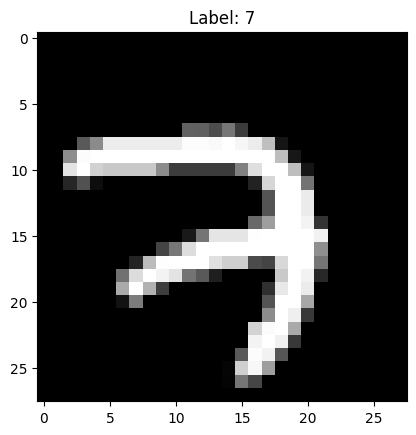

In [ ]:
n = 5000
image, label = train_dataset.data[n], train_dataset.targets[n]

# 이미지 시각화
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [ ]:
x_val, x_test = test_dataset.data[:5000], test_dataset.data[5000:]
y_val, y_test = test_dataset.targets[:5000], test_dataset.targets[5000:]
x_val.shape, y_val.shape

(torch.Size([5000, 28, 28]), torch.Size([5000]))

In [ ]:
x_val = x_val / 255
x_test = x_test / 255

In [ ]:
x_val = x_val.view(5000, 1, 28, 28)
x_test = x_test.view(5000, 1, 28, 28)
print(x_val.shape, x_test.shape)

torch.Size([5000, 1, 28, 28]) torch.Size([5000, 1, 28, 28])


### (2) 모델링

In [ ]:
n_feature = 28 * 28
n_class = 10

# 모델 구조 설계
model = nn.Sequential(nn.Flatten(),
    nn.Linear(n_feature, n_class)
    ).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 10
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val, y_val, model, loss_fn, device)
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f'Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}')

Epoch 1, train loss : 0.550297, val loss : 0.427710
Epoch 2, train loss : 0.329139, val loss : 0.378382
Epoch 3, train loss : 0.300108, val loss : 0.360171
Epoch 4, train loss : 0.286235, val loss : 0.351113
Epoch 5, train loss : 0.277704, val loss : 0.345912
Epoch 6, train loss : 0.271742, val loss : 0.342649
Epoch 7, train loss : 0.267243, val loss : 0.340480
Epoch 8, train loss : 0.263675, val loss : 0.338987
Epoch 9, train loss : 0.260744, val loss : 0.337942
Epoch 10, train loss : 0.258274, val loss : 0.337209


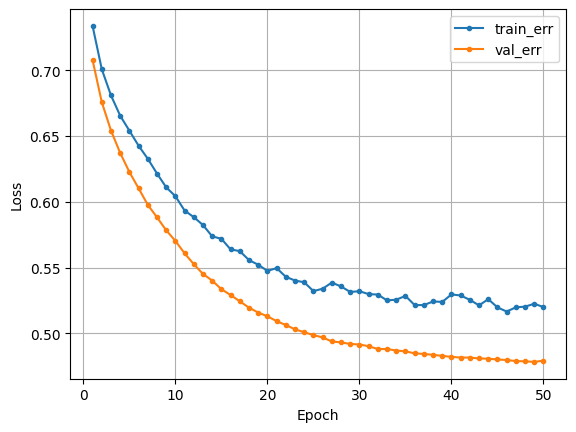

In [ ]:
# 학습 곡선
dl_learning_curve(tr_loss_list, val_loss_list)

In [ ]:
_, pred = evaluate(x_test, y_test, model, loss_fn, device)
pred = nn.functional.softmax(pred, dim=1)
print(pred[:5])

tensor([[1.1945e-03, 7.6238e-06, 8.7156e-04, 6.3656e-01, 4.0733e-04, 3.5652e-01,
         3.0519e-06, 1.0840e-05, 3.7450e-03, 6.8078e-04],
        [2.6886e-04, 7.9655e-08, 3.3279e-03, 9.0292e-03, 2.7743e-01, 4.1305e-03,
         3.8761e-04, 3.7396e-03, 2.2827e-01, 4.7342e-01],
        [7.7717e-07, 2.9300e-11, 1.3405e-07, 1.5390e-06, 5.2491e-03, 1.3186e-06,
         1.2832e-07, 8.0860e-04, 2.3939e-03, 9.9154e-01],
        [2.3248e-07, 1.3117e-09, 1.0306e-06, 5.0072e-06, 2.9858e-07, 2.8151e-04,
         1.0188e-08, 2.3315e-08, 9.9926e-01, 4.4829e-04],
        [7.5437e-05, 7.3456e-12, 3.7862e-06, 1.1424e-07, 9.9840e-01, 2.5413e-05,
         6.1143e-05, 2.9678e-05, 1.5170e-04, 1.2531e-03]])


In [ ]:
pred = np.argmax(pred.cpu().numpy(), axis = 1)
print(pred[:5])

[3 9 9 8 4]


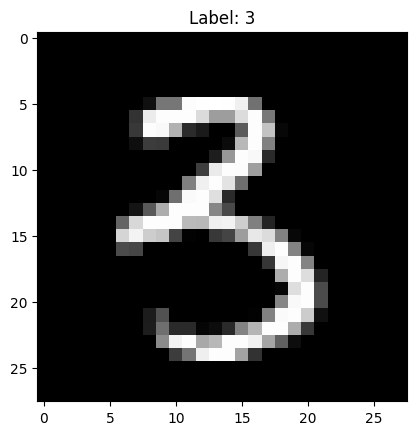

In [ ]:
n = 0
image, label = test_dataset.data[5000+n], test_dataset.targets[5000+n]
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

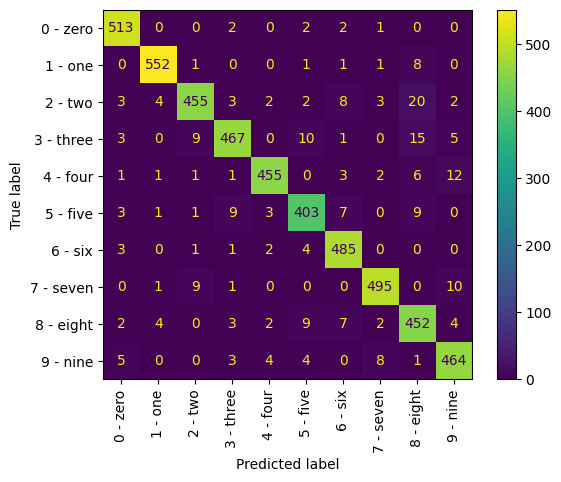

In [ ]:
cm = confusion_matrix(y_test.numpy(), pred)
disp = ConfusionMatrixDisplay(cm, display_labels = train_dataset.classes)
disp.plot()
plt.xticks(rotation=90)
plt.show()

In [ ]:
print(classification_report(y_test.numpy(), pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       520
           1       0.98      0.98      0.98       564
           2       0.95      0.91      0.93       502
           3       0.95      0.92      0.93       510
           4       0.97      0.94      0.96       482
           5       0.93      0.92      0.93       436
           6       0.94      0.98      0.96       496
           7       0.97      0.96      0.96       516
           8       0.88      0.93      0.91       485
           9       0.93      0.95      0.94       489

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



### (3) 은닉층 추가

In [ ]:
n_feature = 28 * 28
n_class = 10
# 모델 구조 설계
model = nn.Sequential(nn.Flatten(),
            nn.Linear(n_feature, 20), nn.ReLU(),
            nn.Linear(20, n_class)
            ).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 10
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss,_ = evaluate(x_val, y_val, model, loss_fn, device)
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f'Epoch {t+1}, train loss : {tr_loss:4f}, val loss : {val_loss:4f}')

Epoch 1, train loss : 0.522643, val loss : 0.387016
Epoch 2, train loss : 0.288411, val loss : 0.337442
Epoch 3, train loss : 0.254492, val loss : 0.301076
Epoch 4, train loss : 0.228331, val loss : 0.276308
Epoch 5, train loss : 0.207776, val loss : 0.259158
Epoch 6, train loss : 0.191900, val loss : 0.247019
Epoch 7, train loss : 0.179561, val loss : 0.237413
Epoch 8, train loss : 0.169290, val loss : 0.228829
Epoch 9, train loss : 0.160865, val loss : 0.222113
Epoch 10, train loss : 0.153605, val loss : 0.218326


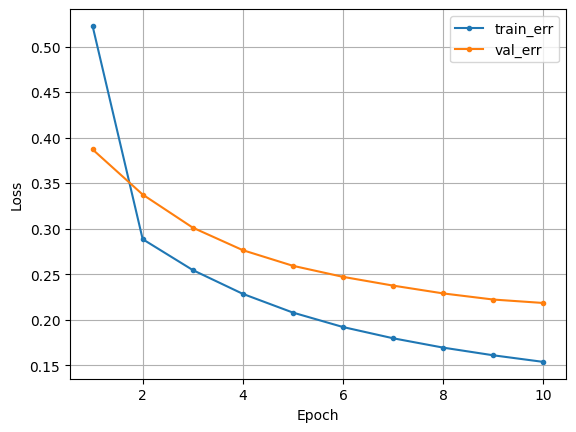

In [ ]:
# 학습 곡선
dl_learning_curve(tr_loss_list, val_loss_list)

In [ ]:
_, pred = evaluate(x_test, y_test, model, loss_fn, device)
pred = nn.functional.softmax(pred, dim=1)
print(pred[:5])

tensor([[3.3635e-05, 1.8447e-06, 4.1542e-05, 3.5456e-01, 4.1489e-05, 6.4493e-01,
         1.6877e-07, 4.9157e-06, 2.0607e-04, 1.7685e-04],
        [1.4537e-05, 2.0235e-08, 9.2834e-05, 1.0988e-03, 2.8347e-02, 2.2638e-03,
         8.6038e-06, 3.8834e-04, 1.4386e-01, 8.2392e-01],
        [2.6363e-08, 7.5021e-14, 1.8791e-08, 2.2764e-08, 3.1599e-04, 4.9960e-06,
         2.9835e-09, 2.2276e-06, 9.7069e-05, 9.9958e-01],
        [5.2874e-10, 1.0914e-10, 5.2262e-09, 2.7640e-07, 3.9361e-08, 4.7381e-05,
         1.5164e-10, 8.4731e-11, 9.9992e-01, 3.4073e-05],
        [8.7281e-08, 6.0171e-14, 9.4906e-07, 1.9347e-09, 9.9940e-01, 2.5665e-04,
         1.0121e-05, 2.9039e-07, 5.8144e-06, 3.2251e-04]])


In [ ]:
pred = np.argmax(pred.cpu().numpy(), axis = 1)
print(pred[:5])

[5 9 9 8 4]


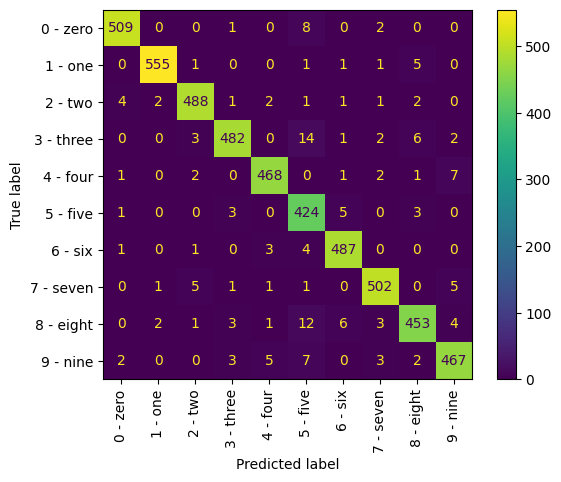

In [ ]:
cm = confusion_matrix(y_test.numpy(), pred)
disp = ConfusionMatrixDisplay(cm, display_labels = train_dataset.classes)
disp.plot()
plt.xticks(rotation=90)
plt.show()

In [ ]:
print(classification_report(y_test.numpy(), pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       520
           1       0.99      0.98      0.99       564
           2       0.97      0.97      0.97       502
           3       0.98      0.95      0.96       510
           4       0.97      0.97      0.97       482
           5       0.90      0.97      0.93       436
           6       0.97      0.98      0.98       496
           7       0.97      0.97      0.97       516
           8       0.96      0.93      0.95       485
           9       0.96      0.96      0.96       489

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



* 확률값을 잘라 0과 1로 변환

In [ ]:
pred = np.where(pred.numpy() > .5, 1, 0)
print(pred[:5])

[[0]
 [0]
 [0]
 [0]
 [0]]


* 성능 평가

In [ ]:
print(confusion_matrix(y_val_ts.numpy(), pred))

[[114  21]
 [ 24  55]]


In [ ]:
print(classification_report(y_val_ts.numpy(), pred))

              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84       135
         1.0       0.72      0.70      0.71        79

    accuracy                           0.79       214
   macro avg       0.77      0.77      0.77       214
weighted avg       0.79      0.79      0.79       214

